In [612]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
from konlpy.tag import Komoran
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

In [613]:
train_data = pd.read_csv("test.csv",encoding='CP949')

In [614]:
train_data

KEYWORD_CD            CONTENT  LABEL        DATE
0          필링기  제품은 이도 저도 아닌 딱 보통      0  2022.03.03
1          필링기       이도저도 아닌 딱 보통      0  2022.03.03
2          필링기            그냥 씁니다.      0  2022.03.03
3          필링기           그냥 사용합시다      0  2022.03.03
4          필링기              보통이에요      0  2022.03.03
..         ...                ...    ...         ...
100        필링기         쓰레기 제품입니다.     -1  2022.03.05
101        필링기             좋아요좋아요      1  2022.03.05
102        필링기              별롱비니다     -1  2022.03.05
103        필링기             쓰레기 제품     -1  2022.03.05
104        필링기           이제품은 쓰레기     -1  2022.03.05

[105 rows x 4 columns]

In [615]:
test_data = pd.read_csv("testtest.csv" ,encoding='CP949')

In [616]:
test_data

KEYWORD_CD                                            CONTENT  LABEL   
0         필링기                                  제품은 이도 저도 아닌 딱 보통      0  \
1         필링기                                       이도저도 아닌 딱 보통      0   
2         필링기                                            그냥 씁니다.      0   
3         필링기                                           그냥 사용합시다      0   
4         필링기                                              보통이에요      0   
5         필링기                                              긍정입니다      1   
6         필링기                                            절대 안사용함     -1   
7         필링기                                                좋아요      1   
8         필링기                                             제품 좋아요      1   
9         필링기                                       긍정 긍정 긍정 합니다      1   
10        필링기                                               딱 보통      0   
11        필링기                                           다시는 구매안함     -1   
12        필링기                                         절대적으로 안사용함     -1   
13        필링기                                              보통이에요      0   
14        필링기                                              보통이에요      0   
15        필링기                                              보통이에요      0   
16        필링기                              많이 달지않코 식어도 계속 빠삭해요..      1   
17        필링기      너무 맛있어요 !! 이제 붕세권따윈 의미가 없네요   너무 빠삭하고 맛있어요 !!      1   
18        필링기                       먹고싶을 때마다 에어프라이어에 구워 먹으니 맛나요.      1   
19        필링기                 에어프라이기 180도 10분 돌렸는데 빠삭빠삭 맛있어요????      1   
20        필링기  진짜 맛있어요 팥도 많이 달지않고 가득들고 피?는얇아요 에어프라이어 돌리면 파는거보...      0   
21        필링기                                    다조은데 아주약간짭아요 ㅋㅋ      0   
22        필링기                              시중에서 파는 맛과 90%정도 일치해요      0   
23        필링기                             오븐해서 먹으니 파는 붕어빵보다 맛나요.      1   
24        필링기                                           쓸만하고 좋아요      1   
25        필링기                                                 긍정      1   
26        필링기                                           좋고 긍정입니다      1   
27        필링기                                            좋은데 좋아요      1   
28        필링기                                      재구매 의사 확실히 있음      1   
29        필링기                                              그냥 저럭      0   
30        필링기                                         쓰레기 제품입니다.     -1   
31        필링기                                             좋아요좋아요      1   
32        필링기                                              별롱비니다     -1   
33        필링기                                             쓰레기 제품     -1   
34        필링기                                           이제품은 쓰레기     -1   

          DATE  
0   2022.03.03  
1   2022.03.03  
2   2022.03.03  
3   2022.03.03  
4   2022.03.03  
5   2022.03.03  
6   2022.03.03  
7   2022.03.03  
8   2022.03.03  
9   2022.03.03  
10  2022.03.03  
11  2022.03.03  
12  2022.03.03  
13  2022.03.03  
14  2022.03.03  
15  2022.03.03  
16  2022.03.01  
17  2022.03.01  
18  2022.03.01  
19  2022.03.01  
20  2022.03.02  
21  2022.03.03  
22  2022.03.04  
23  2022.03.05  
24  2022.03.05  
25  2022.03.05  
26  2022.03.05  
27  2022.03.05  
28  2022.03.05  
29  2022.03.05  
30  2022.03.05  
31  2022.03.05  
32  2022.03.05  
33  2022.03.05  
34  2022.03.05

In [617]:
train_data['LABEL'] = train_data['LABEL'].replace([0, 1, -1],[0, 1, 2])
test_data['LABEL'] = test_data['LABEL'].replace([0, 1, -1],[0, 1, 2])

<Axes: xlabel='LABEL'>

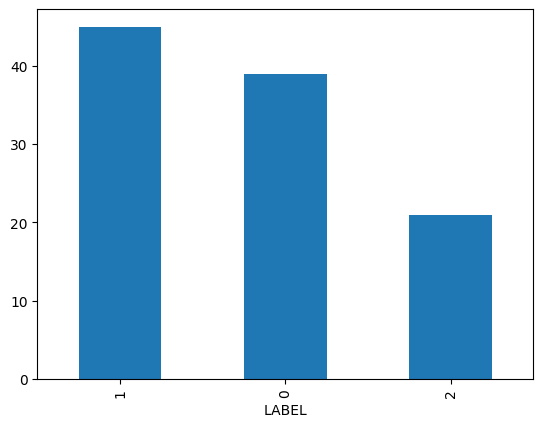

In [618]:
train_data['LABEL'].value_counts().plot(kind='bar')

In [619]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [620]:
train_data['CONTENT'] = train_data['CONTENT'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data['CONTENT'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거

In [621]:
test_data['CONTENT'] = test_data['CONTENT'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
test_data['CONTENT'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

In [622]:
okt = Okt()
def preprocess_text(data):
    data['CONTENT'] = data['CONTENT'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
    data['CONTENT'].replace('', np.nan, inplace=True)
    data.dropna(how='any', inplace=True) 
    data['tokenized'] = data['CONTENT'].apply(okt.morphs)
    data['tokenized'] = data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
    return data

In [623]:
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

In [624]:
# 토큰화 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tokenized'])
X_train = tokenizer.texts_to_sequences(train_data['tokenized'])
X_test = tokenizer.texts_to_sequences(test_data['tokenized'])

In [625]:
# 패딩
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [626]:
# 레이블 원-핫 인코딩
y_train = to_categorical(train_data['LABEL'])
y_test = to_categorical(test_data['LABEL'])


In [627]:
print(y_train)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1.

In [628]:
# 모델 구성
vocab_size = len(tokenizer.word_index) + 1  # 단어 사전 크기
embedding_dim = 128  # 임베딩 차원
hidden_units = 128  # LSTM 유닛 수

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(3, activation='softmax'))  # 3개의 출력 레이어 (긍정, 부정, 중립)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 클래스 가중치 계산
classes = np.unique(np.argmax(y_train, axis=1))
class_weights = compute_class_weight('balanced', classes=classes, y=classes)
class_weight_dict = dict(zip(classes, class_weights))

# 콜백 설정 (조기 종료 및 최적 모델 저장)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# 모델 학습
#history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping, checkpoint])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2,
                    class_weight=class_weight_dict, callbacks=[early_stopping, checkpoint])
# 모델 평가
model = load_model('best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_acc))

2024-03-07 02:44:20.532781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-07 02:44:20.534502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-07 02:44:20.535621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-03-07 02:44:23.108504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-07 02:44:23.110326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-07 02:44:23.111550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - ETA: 0s - loss: 1.0935 - accuracy: 0.4048 

2024-03-07 02:44:39.085388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-07 02:44:39.087220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-07 02:44:39.088397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 20s 5s/step - loss: 1.0935 - accuracy: 0.4048 - val_loss: 1.0584 - val_accuracy: 0.6190
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 1.0591 - accuracy: 0.5238 - val_loss: 1.0622 - val_accuracy: 0.2857
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 1.0537 - accuracy: 0.3929 - val_loss: 1.0340 - val_accuracy: 0.5238
Epoch 4/10
2/2 [==============================] - 3s 1s/step - loss: 1.0449 - accuracy: 0.4643 - val_loss: 1.0038 - val_accuracy: 0.5238
Epoch 5/10
2/2 [==============================] - 3s 1s/step - loss: 1.0332 - accuracy: 0.4048 - val_loss: 0.9935 - val_accuracy: 0.5238
Epoch 6/10
2/2 [==============================] - 3s 1s/step - loss: 1.0206 - accuracy: 0.4048 - val_loss: 0.9827 - val_accuracy: 0.5238
Epoch 7/10
2/2 [==============================] - 3s 1s/step - loss: 1.0040 - accuracy: 0.4762 - val_loss: 0.9514 - val_accuracy: 0.6667
Epoch 8/10
2/2 [==============================] - 3

2024-03-07 02:45:08.099680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-07 02:45:08.101467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-07 02:45:08.102593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 3s 135ms/step - loss: 0.5694 - accuracy: 0.8000
Test Loss: 0.5694, Test Accuracy: 0.8000


In [629]:
def predict_sentiment(text):
    # 1. 사용자 입력 텍스트 전처리
    text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", text)
  
    tokenized_text = okt.morphs(text)
 
    tokenized_text = [word for word in tokenized_text if word not in stopwords]
   
    # 2. 텍스트 토큰화 및 패딩
    encoded_text = tokenizer.texts_to_sequences([tokenized_text])
   
    padded_text = pad_sequences(encoded_text, maxlen=max_len)
  

    # 3. 예측 수행
    score = model.predict(padded_text)
    print(score)
    label = np.argmax(score, axis=1)
    print(label)
    # 4. 결과 출력
    if label == 0:
        print("중립")
    elif label == 1:
        print("긍정")
    else:
        print("부정")

In [630]:
#사용자 입력 예시
user_input = "긍정입니다"
predict_sentiment(user_input)

2024-03-07 02:45:14.226242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-07 02:45:14.227633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-07 02:45:14.229066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step
[[0.24383551 0.5696524  0.1865121 ]]
[1]
긍정


In [631]:
# 모델 예측 및 F1 점수 계산
from sklearn.metrics import f1_score, classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

f1_micro = f1_score(y_true, y_pred_classes, average='micro')

print(f'F1 score: {f1_micro:.2f}')


2/2 [==============================] - 1s 143ms/step
F1 score: 0.80
